<h1> Build dataframe for woreda level malaria prediction </h1>

<h1> Load Lat Lon mapping from CSV file </h1>

In [3]:
from __future__ import division
import numpy as np
import json
import re
import gzip
import pandas as pd
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
import seaborn as sns
import datetime
import csv

from ethiopian_date import ethiopian_date

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<h1> load in Regional and Woreda level map </h1>

In [4]:
lat_lon_map = dict()
# RegionName, RegionLat, RegionLon
fpath = '/Users/attiladobi/zenysis/pipeline/auto/ethiopia/bin/shared/data/region_mapped.csv'
with open(fpath, 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    # skip one row
    spamreader.next()
    for row in spamreader:
        lat_lon_map[row[0]] = (row[1], row[2])
lat_lon_map

{'Addis Ababa': ('8.980483001254077', '38.78553834507309'),
 'Afar': ('12.036445063176075', '40.772735414805204'),
 'Amhara': ('11.5649524790046', '38.04353615460529'),
 'Benishangul-Gumuz': ('10.502924415157686', '35.44030701966273'),
 'Dire Dawa': ('9.606269193503696', '42.003026894902156'),
 'Gambella': ('7.683850454124325', '34.33675414861345'),
 'Harreri': ('9.289660023774802', '42.172525872858124'),
 'Oromiya': ('7.323567398452454', '38.66052453790127'),
 'SNNPR': ('6.465808724769859', '36.806469462905675'),
 'Somali': ('6.932778405509416', '43.32988331430246'),
 'Tigray': ('13.777114742142253', '38.43867332133363')}

In [36]:
def gen_woreda_key(region, zone, woreda):
    return '%s__%s__%s' % (region.lower().replace(' ','_'), \
                           zone.lower().replace(' ','_'), \
                           woreda.lower().replace(' ','_') )

woreda_lat_lon_map = dict()
# RegionName, RegionLat, RegionLon
fpath = '/Users/attiladobi/zenysis/pipeline/auto/ethiopia/bin/shared/data/woreda_mapped.csv'
with open(fpath, 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    # skip one row
    spamreader.next()
    for row in spamreader:
        woreda_lat_lon_map[gen_woreda_key(row[0], row[1], row[2]) ] = \
                            {'RegionName': row[0], 'ZoneName': row[1], 'WoredaName': row[2], \
                            'RegionLat': row[3], 'RegionLon': row[4]}
#woreda_lat_lon_map

<h1> load in indicator ID mapping </h1>

In [8]:
import sys
sys.path.append('/Users/attiladobi/zenysis')
import config.et.indicators

useful_groups = config.indicators.HMIS_GROUPS + [config.indicators.CALCULATED_INDICATOR_GROUP]
IDlookup = {val['id']:val for cluster in useful_groups for val in cluster['indicators']}

<h1> Load in woreda level malaria data </h1>

In [6]:
with open('/Users/attiladobi/Downloads/malaria_woreda.json', 'rb') as f:
    data = f.readlines()
# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"

# now, load it into pandas
DF2 = pd.read_json(data_json_str)

In [18]:
df_list = []
for full_name in DF2['byGeo'][0].keys():
    region_name, zone_name, woreda_name = full_name.split('__')[:3]
    meta_data = pd.DataFrame(DF2['byGeo'][0][full_name]['data']['month'])
    formatted_data = pd.DataFrame(meta_data[1:].stack()).reset_index(level=0)
    
    formatted_data.index = [pd.to_datetime(val) for val in formatted_data.index]
    formatted_data.columns = ['Indicator_id', 'val']
    formatted_data.index.name = 'Real_Date'
    formatted_data['RegionName'] = region_name
    formatted_data['ZoneName'] = zone_name
    formatted_data['WoredaName'] = woreda_name
    df_list.append(formatted_data)
DF_ind=pd.concat(df_list)
DF_ind['Indicator'] = [IDlookup[val]['text'] for val in DF_ind['Indicator_id']]

#Note: region_name, zone_name, woreda_name are all lower case

<h3> look up woreda lat and log based on region, zone, woreda </h3>

In [71]:
DF_ind['RegionLat'] = [woreda_lat_lon_map[gen_woreda_key(region, zone, woreda)]['RegionLat'] \
                       for region, zone, woreda in DF_ind[['RegionName', 'ZoneName', 'WoredaName']].values]
DF_ind['RegionLon'] = [woreda_lat_lon_map[gen_woreda_key(region, zone, woreda)]['RegionLon'] \
                       for region, zone, woreda in DF_ind[['RegionName', 'ZoneName', 'WoredaName']].values]

<h3> At the end we need to look up the cananical WoredaName, ZoneName, RegionName </h3>

In [72]:
DF_ind

,Indicator_id,val,RegionName,ZoneName,WoredaName,Indicator,RegionLat,RegionLon
Real_Date,,,,,,,,
2014-07-08,hmis_c_1_4_2_5_4,0,afar,afar,berahle,Proportion of targeted HH covered with LLIN in...,13.839480500786149,40.430073860926576
2014-08-07,hmis_c_1_4_2_5_4,0,afar,afar,berahle,Proportion of targeted HH covered with LLIN in...,13.839480500786149,40.430073860926576
2014-09-11,hmis_c_1_4_2_5_4,0,afar,afar,berahle,Proportion of targeted HH covered with LLIN in...,13.839480500786149,40.430073860926576
2014-10-11,hmis_c_1_4_2_5_4,0,afar,afar,berahle,Proportion of targeted HH covered with LLIN in...,13.839480500786149,40.430073860926576
2014-11-10,hmis_c_1_4_2_5_4,0,afar,afar,berahle,Proportion of targeted HH covered with LLIN in...,13.839480500786149,40.430073860926576
2014-12-10,hmis_c_1_4_2_5_4,0,afar,afar,berahle,Proportion of targeted HH covered with LLIN in...,13.839480500786149,40.430073860926576
2015-01-09,hmis_c_1_4_2_5_4,0,afar,afar,berahle,Proportion of targeted HH covered with LLIN in...,13.839480500786149,40.430073860926576
2015-02-08,hmis_c_1_4_2_5_4,0,afar,afar,berahle,Proportion of targeted HH covered with LLIN in...,13.839480500786149,40.430073860926576
2015-03-10,hmis_c_1_4_2_5_4,0,afar,afar,berahle,Proportion of targeted HH covered with LLIN in...,13.839480500786149,40.430073860926576


In [74]:
DF_ind.reset_index().to_csv('Malaria_Woreda_Level.csv')

In [86]:
prev_val.astype(float)

array([ 18.,  24.,  11., ...,   5.,   0.,   6.])

In [79]:
len(prev_val)

22290

In [104]:
import matplotlib as mpl

In [109]:
my_cmap = plt.cm.jet
my_cmap.set_under('w',1)

In [144]:
DF_ind.drop(0)
DF_ind['val_shift'] = DF_ind.shift().val
DF_ind['WoredaName_shift'] = DF_ind.shift().WoredaName

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in true_divide


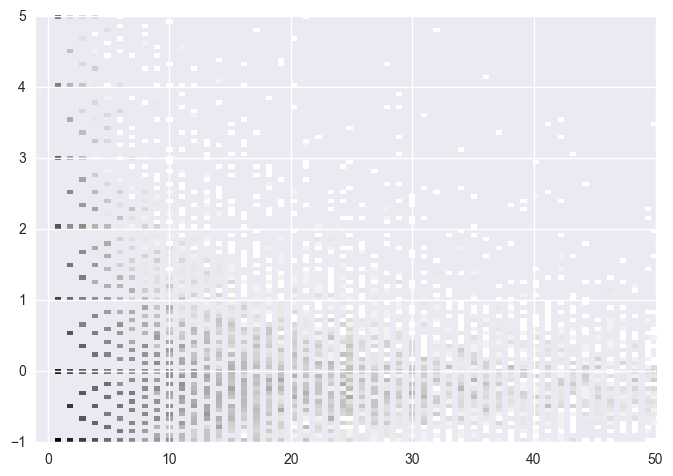

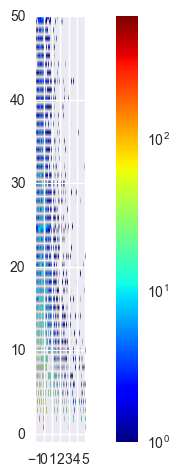

In [162]:
cur_val = DF_ind[(DF_ind['Indicator'].str.contains('Number of slides or RDT positive for malaria 5-14 years: Females')) \
                & (DF_ind['WoredaName_shift'] == DF_ind['WoredaName']) ]\
.val.values.astype(float)

prev_val = DF_ind[(DF_ind['Indicator'].str.contains('Number of slides or RDT positive for malaria 5-14 years: Females')) \
                 & (DF_ind['WoredaName_shift'] == DF_ind['WoredaName'])]\
.val_shift.values.astype(float)

#plt.hist2d(prev_val, cur_val, bins=100, range= [[0, 100], [0, 100]], norm=mpl.colors.LogNorm(), vmin=1, cmax=10 )
#xscale('log')
#yscale('log')
#xlim([0,200])
#ylim([0,200])

H, xedges, yedges, img = plt.hist2d(prev_val, (cur_val-prev_val) / prev_val, bins=100, range= [[-1, 50], [-1, 5]], norm=mpl.colors.LogNorm() )
extent = [yedges[0], yedges[-1], xedges[0], xedges[-1]]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(H[::-1], cmap=plt.cm.jet, extent=extent, norm=mpl.colors.LogNorm())
fig.colorbar(im, ax=ax)
#plt.show()

(0, 100)

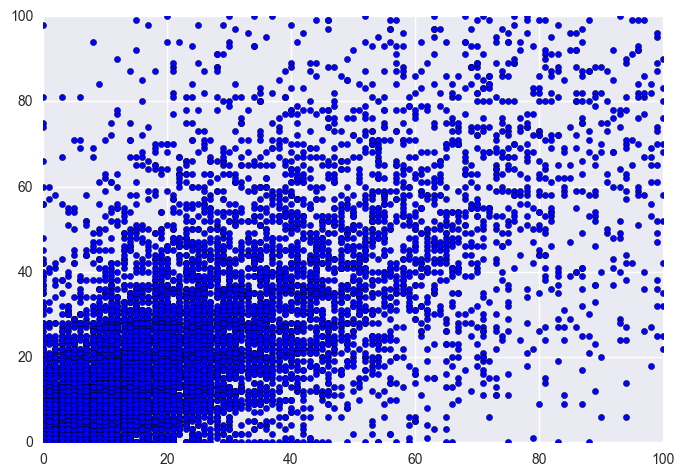

In [147]:
plt.scatter(prev_val, cur_val)
xlim([0,100])
ylim([0,100])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


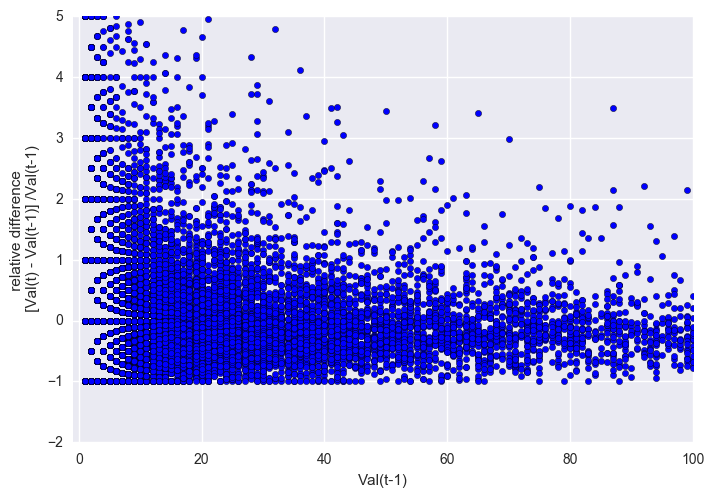

In [163]:
plt.scatter(prev_val, (cur_val-prev_val) / prev_val)
ylim([-2, 5])
xlim([-1, 100])
xlabel('Val(t-1)')
ylabel(' relative difference \n [Val(t) - Val(t-1)] /Val(t-1)' )